In [ ]:
Latar Belakang
Penyusunan strategi pemasaran dalam melakukan penjualan merupakan hal yang sangat penting untuk dilakukan. 
Hal ini berkaitan dengan bagaimana meningkatkan keuntungan serta eksistensi dari usaha yang dijalankan. 
Dengan adanya strategi yang jelas dan terarah, maka peningkatan keuntungan pada penjualan yang dilakukan akan terealisasi. 
Dalam hal ini, untuk meningkatkan keuntungan dalam penjualan buku, maka dilakukan analisis terhadap review dari buku yang dijual.
Analisis terhadap review tersebut dilakukan untuk mengekstraksi informasi yang terdapat pada review buku yang diberikan oleh pelanggan. 


In [11]:
import cv2
import imutils
import nltk 
import string
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from imutils import paths
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score,cross_val_predict
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from contractions import contractions_dict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier

In [12]:
def load_data(path):
    dataset_review = pd.read_excel(path, encoding='utf-8')
    return  dataset_review 


In [13]:
dataset_review = pd.read_excel('C:/Users/LENOVO/Ekperimen/Data Eksperimen/Data Review/Data_model_sentimen.xlsx')

dataset_review.head(5)

,Review,Rating,Sentimen,Label
0,"The Keto Diet, by Leanne Vogel, was my first k...",3,Positif,1
1,To many ingredients unless it’s a holiday.,2,Negatif,0
2,"Information is there, meal plans exceed the re...",3,Negatif,0
3,Simple not too many recipes but does the trick,3,Negatif,0
4,Hope you like cream cheese,3,Positif,1


In [14]:
len(dataset_review)

5244

In [15]:
pos = len([x for x in dataset_review['Sentimen'] if x == 'Positif'])
neg = len([x for x in dataset_review['Sentimen'] if x == 'Negatif'])

pos,neg

(2743, 2501)

Data PreProcessing

In [16]:
def NER(review):
    for i in range(len(review)):
        text = review.Review.iloc[i]
        for sent in nltk.sent_tokenize(text):
            for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
                if hasattr(chunk, 'label') and chunk.label:
                    if chunk.label() == 'ORGANIZATION' or  chunk.label() == 'PERSON' or  chunk.label() == 'DATE' or  chunk.label() == 'LOCATION':
                        name_value = ' '.join(child[0] for child in chunk.leaves())
                        text = text.replace(name_value, "")
                        review.Review.iloc[i] = text
    return review

In [17]:
def case_folding(review):
    for i in range(len(review)):
        text = review.Review[i].lower()
        review.Review.iloc[i] = text 
    return review

In [18]:
def remove_punctuation(review):
    remove = string.punctuation
    for i in range(len(review)):
        for kata in remove:
            text = review.Review[i].replace(kata,"")
            review.Review.iloc[i] = text 
    return review

In [19]:
def stop_removal(review):
    from nltk.tokenize import sent_tokenize, word_tokenize
    cachedStopWords = set(stopwords.words("english"))
    for i in range(len(review)):
        text = review.Review.iloc[i]
        teks =" ".join([word for word in text.split() if word not in cachedStopWords])
        review.Review.iloc[i] = teks
    return review

In [20]:
def stemming(review):
    ps = PorterStemmer()
    for i in range(len(review)):
        text = review.Review.iloc[i]
        text = ps.stem(text)
        review.Review.iloc[i] = text
    return review

In [21]:
def lemmatization (review):
    lm = WordNetLemmatizer()
    for i in range(len(review)):
        text = review.Review.iloc[i]
        text = lm.lemmatize(text)
        review.Review.iloc[i] = text
    return review

In [22]:
def preprocessing_data(review):
    hasil_ner = NER(review)
    hasil_case_folding = case_folding(hasil_ner)
    hasil_remove_punctuation = NER(review)
    hasil_stop_removal = stop_removal(hasil_remove_punctuation)
    hasil_stemming = stemming( hasil_stop_removal)
    hasil_lemmatization = lemmatization(hasil_stemming)
    return hasil_lemmatization
    

In [23]:
data_clean = preprocessing_data(dataset_review)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
data_clean

,Review,Rating,Sentimen,Label
0,", , first keto book. book use daily basis grow...",3,Positif,1
1,many ingredients unless it’s holiday.,2,Negatif,0
2,"information there, meal plans exceed recommend...",3,Negatif,0
3,simple many recipes trick,3,Negatif,0
4,hope like cream chees,3,Positif,1
5,like recipes. would liked single portion measu...,2,Negatif,0
6,easy informative. great recipes. food choices ...,1,Positif,1
7,finish reading. complicate food plan,3,Positif,1
8,can't endorse diet. much fat food restrictions...,3,Positif,1
9,redundant. author clearly told lost 120 pounds...,1,Positif,1


In [25]:
# load SVM model untuk klasifikasi
filename1= 'C:/Users/LENOVO/Ekperimen/Eksperimen Model Sentimen/Model Sentimen/model_sentimen.pkl'
loaded_model = pickle.load(open(filename1, 'rb'))

# load SVM feature for klasifikasi
filename1='C:/Users/LENOVO/Ekperimen/Eksperimen Model Sentimen/feature.pkl'
loaded_feature = pickle.load(open(filename1, 'rb'))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.19.0 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [26]:
import re
pattern=r'[^a-zA-Z]'
for i in range(len(data_clean)):
    data_clean['Review'].iloc[i] = re.sub(pattern,' ', data_clean['Review'].iloc[i], flags=re.MULTILINE)
data_clean.head(10)

,Review,Rating,Sentimen,Label
0,first keto book book use daily basis grow...,3,Positif,1
1,many ingredients unless it s holiday,2,Negatif,0
2,information there meal plans exceed recommend...,3,Negatif,0
3,simple many recipes trick,3,Negatif,0
4,hope like cream chees,3,Positif,1
5,like recipes would liked single portion measu...,2,Negatif,0
6,easy informative great recipes food choices ...,1,Positif,1
7,finish reading complicate food plan,3,Positif,1
8,can t endorse diet much fat food restrictions...,3,Positif,1
9,redundant author clearly told lost pounds...,1,Positif,1


In [27]:
y = data_clean.Sentimen
data_clean.Review

0           first keto book  book use daily basis grow...
1                   many ingredients unless it s holiday 
2       information there  meal plans exceed recommend...
3                               simple many recipes trick
4                                   hope like cream chees
5       like recipes  would liked single portion measu...
6       easy informative  great recipes  food choices ...
7                    finish reading  complicate food plan
8       can t endorse diet  much fat food restrictions...
9       redundant  author clearly told lost     pounds...
10                                               interest
11      different keto essentials  even lots recipes l...
12      never used recipes  i m feel like food me  res...
13      books definitely used be  i ve read can t get ...
14      maybe set expectations high  book anticlimacti...
15      favorite book  spoiler alert  ends abruptly re...
16      found book mundane many pages  plot little unb...
17      i ve n

In [28]:
hasil_preprocessing= dataset_review.to_excel('data_after_preprocessing.xlsx', encoding='utf-8')

In [26]:
new_data = pd.read_excel('C:/Users/LENOVO/data_after_preprocessing.xlsx')

In [44]:
new_data.Review

0           first keto book  book use daily basis grow...
1                   many ingredients unless it s holiday 
2       information there  meal plans exceed recommend...
3                               simple many recipes trick
4                                   hope like cream chees
5       like recipes  would liked single portion measu...
6       easy informative  great recipes  food choices ...
7                    finish reading  complicate food plan
8       can t endorse diet  much fat food restrictions...
9       redundant  author clearly told lost     pounds...
10                                               interest
11      different keto essentials  even lots recipes l...
12      never used recipes  i m feel like food me  res...
13      books definitely used be  i ve read can t get ...
14      maybe set expectations high  book anticlimacti...
15      favorite book  spoiler alert  ends abruptly re...
16      found book mundane many pages  plot little unb...
17      i ve n

Feature Extraction


In [45]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=1)
X_train_counts = count_vect.fit_transform(data_clean.Review)
print (X_train_counts.shape)
count_vect.vocabulary_

(5244, 6715)


{'first': 2258,
 'keto': 3214,
 'book': 638,
 'use': 6346,
 'daily': 1380,
 'basis': 475,
 'grown': 2603,
 'journey': 3177,
 'sure': 5765,
 'expecting': 2072,
 'maybe': 3599,
 'additional': 70,
 'information': 3002,
 'another': 247,
 'like': 3393,
 'nd': 3855,
 'favorite': 2197,
 'right': 5007,
 'now': 3954,
 'buy': 761,
 'again': 127,
 'easier': 1802,
 'navigate': 3852,
 'opinion': 4043,
 'clearly': 984,
 'many': 3552,
 'people': 4230,
 'love': 3476,
 'good': 2516,
 'but': 754,
 'ingredients': 3011,
 'unless': 6289,
 'it': 3138,
 'holiday': 2778,
 'there': 5937,
 'meal': 3607,
 'plans': 4326,
 'exceed': 2033,
 'recommended': 4778,
 'max': 3597,
 'carb': 805,
 'count': 1273,
 'asked': 345,
 'support': 5757,
 'via': 6405,
 'facebook': 2126,
 'page': 4138,
 'website': 6511,
 'nothing': 3943,
 'keep': 3209,
 'cookbook': 1240,
 'only': 4033,
 'believe': 527,
 'says': 5113,
 'help': 2724,
 'isn': 3135,
 'simple': 5328,
 'recipes': 4767,
 'trick': 6137,
 'hope': 2803,
 'cream': 1307,
 'chees

In [46]:
import pickle
with open('C:/Users/LENOVO/Ekperimen/Eksperimen Model Sentimen/feature.pkl', 'wb') as f:
    pickle.dump(count_vect, f)
print('saved featured in ', './feature.pkl')

saved featured in  ./feature.pkl


In [47]:
# Hasil dari tahap count vectorizer digunakan sebagai data yang akan diolah pada tahap TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print (X_train_tfidf.shape)
print(tfidf_transformer.fit_transform(count_vect.fit_transform(data_clean.Review)).toarray())

(5244, 6715)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Eksperimen SVM fitur Model Sentimen


In [48]:
# SVM regularization parameter

C = 1.0  
model_sentimen = SVC(probability=True, kernel='linear', C=C)
model = model_sentimen.fit(X_train_tfidf,y)


In [53]:
# Implementasi K-fold Cross Validation  
# Pengujian menggunakan  10 kali iterasi  

from sklearn.model_selection import KFold 
i = 0
kf = KFold(n_splits=10)
for train, test in kf.split(X_train_tfidf):
    X = X_train_tfidf
    y = y
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    model_sentimen = model_sentimen.fit(X_train,y_train)
    print("classification_report", classification_report(model_sentimen.predict(X_test),y_test))
    with open('model_sentimen '+ str(i)+'.pkl ', 'wb') as f:
        pickle.dump(model_sentimen, f)
        print('model_sentimen',i,' saved in', './model.pkl',i)
        i+= 1

classification_report               precision    recall  f1-score   support

     Negatif       0.77      0.76      0.77       256
     Positif       0.77      0.79      0.78       269

    accuracy                           0.77       525
   macro avg       0.77      0.77      0.77       525
weighted avg       0.77      0.77      0.77       525

model_sentimen 0  saved in ./model.pkl 0
classification_report               precision    recall  f1-score   support

     Negatif       0.74      0.97      0.84       306
     Positif       0.92      0.53      0.67       219

    accuracy                           0.78       525
   macro avg       0.83      0.75      0.75       525
weighted avg       0.82      0.78      0.77       525

model_sentimen 1  saved in ./model.pkl 1
classification_report               precision    recall  f1-score   support

     Negatif       0.71      0.75      0.73       232
     Positif       0.79      0.75      0.77       293

    accuracy                      

In [55]:
from sklearn.model_selection import KFold 
i = 0
performance_model = []

kf = KFold(n_splits=10)
for train, test in kf.split(X_train_tfidf):
    X = X_train_tfidf
    y = y
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    model_sentimen = model_sentimen.fit(X_train,y_train)
    report = classification_report(model_sentimen.predict(X_test),y_test)
    report = report.split()
    performance_model.append([report[19],report[20],report[21]])
    print(report[19],report[20],report[21])
    

0.77 0.77 0.77
0.83 0.75 0.75
0.75 0.75 0.75
0.76 0.76 0.76
0.85 0.83 0.84
0.79 0.79 0.78
0.68 0.65 0.64
0.70 0.71 0.71
0.68 0.68 0.68
0.65 0.60 0.54


In [75]:
model_evaluation = pd.DataFrame(performance_model)
model_evaluation.columns = ['precision','recall','f1-score']

model_evaluation

,precision,recall,f1-score
0,0.77,0.77,0.77
1,0.83,0.75,0.75
2,0.75,0.75,0.75
3,0.76,0.76,0.76
4,0.85,0.83,0.84
5,0.79,0.79,0.78
6,0.68,0.65,0.64
7,0.70,0.71,0.71
8,0.68,0.68,0.68
9,0.65,0.60,0.54


In [76]:

sumprecision = model_evaluation['precision'].astype(float)
avgprecision = sum(sumprecision)/len(sumprecision)
sumrecall = model_evaluation['recall'].astype(float)
avgrecall = sum(sumrecall)/len(sumrecall)
sumfscore = model_evaluation['f1-score'].astype(float)
avgfscore = sum(sumfscore)/len(sumfscore)

print ('precision', 'recall', 'fscore' )
print (avgprecision, avgrecall, avgfscore )

 

precision recall fscore
0.746 0.729 0.722


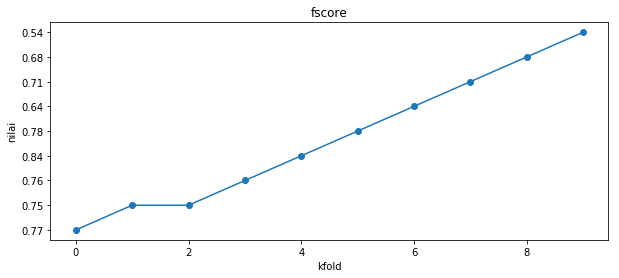

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot( model_evaluation['f1-score'], marker = "o" )
plt.title("fscore")
plt.xlabel("kfold")
plt.ylabel("nilai")
plt.show()

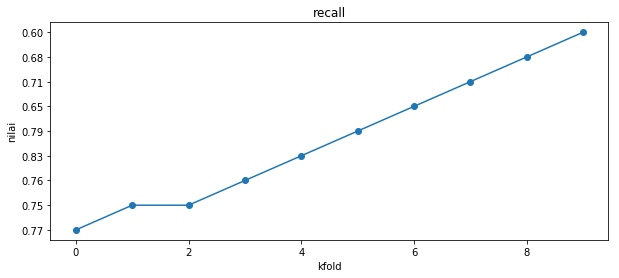

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot( model_evaluation.recall, marker = "o" )

plt.title("recall")
plt.xlabel("kfold")
plt.ylabel("nilai")

plt.show()

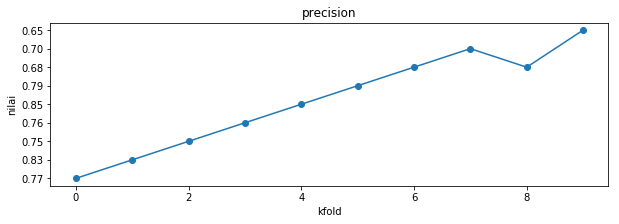

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot( model_evaluation.precision, marker = "o" )

plt.title("precision")
plt.xlabel("kfold")
plt.ylabel("nilai")

plt.show()